In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cross_validation import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn import tree
from numpy.linalg import matrix_rank
from statsmodels.stats.outliers_influence import variance_inflation_factor
%matplotlib inline

//anaconda/lib/python2.7/site-packages/pandas/core/computation/__init__.py:18: UserWarning: The installed version of numexpr 2.4.3 is not supported in pandas and will be not be used
The minimum supported version is 2.4.6

  ver=ver, min_ver=_MIN_NUMEXPR_VERSION), UserWarning)
//anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
//anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:878: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))
//anaconda/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note tha

In [2]:
train = pd.read_csv('./../data/training.csv')
label = pd.read_csv('./../data/labels.csv', header=None)
train.drop('Unnamed: 0', axis=1, inplace=True)
# label encode type 
le = LabelEncoder()
train['type_enc'] = le.fit_transform(train['type'])
label.columns = ['0', 'p_label2']
label.drop('0', axis=1, inplace=True)
y_label = np.ravel(label)

In [3]:
train.columns

Index([u'gasLimit_t', u'gasUsed_t', u'newContract', u'blockTime',
       u'difficulty', u'gasLimit_b', u'gasUsed_b', u'reward', u'size', u'type',
       u'totalFee', u'amount_gwei', u'gasShare', u'gweiPaid', u'gweiPaid_b',
       u'gweiShare', u'free_t', u'day', u'hour', u'dayofweek', u'txcnt_second',
       u'avg_blocktime_6', u'avg_gasUsed_b_6', u'avg_tx_count_6',
       u'avg_uncle_count_6', u'avg_difficulty_6', u'avg_txcnt_second_6',
       u'avg_gasUsed_t_6', u'avg_price_6', u'avg_blocktime_60',
       u'avg_gasUsed_b_60', u'avg_tx_count_60', u'avg_uncle_count_60',
       u'avg_difficulty_60', u'avg_txcnt_second_60', u'avg_gasUsed_t_60',
       u'avg_price_60', u'mv', u'type_enc'],
      dtype='object')

### Columns to remove:

Possible leakage: avg_price_6, avg_price_60, avg_gasUsed_b_6, avg_gasUsed_t_6,  avg_gasUsed_b_60, avg_gasUsed_t_60, avg_price_60

Poor performance: gasLimit_t, gasUsed_t, newContract, avg_uncle_count_6, avg_txcnt_second_6, type_enc, avg_uncle_count_60

### Candidate features:

- avg_difficulty_60, r2=0.99
- avg_tx_count_60, r2=0.5
- avg_blocktime_6, 
- avg_tx_count_6, r2=0.99
- avg_difficulty_6, 
- avg_blocktime_60
- avg_txcnt_second_60, r2=0.12
- mv, r2=0.75

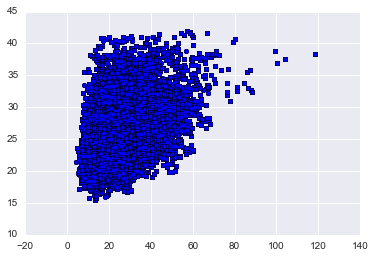

In [4]:
plt.scatter(train['avg_blocktime_6'], train['avg_blocktime_60'])

# Run decision tree

In [26]:
# select features
sub_cols = ['gasLimit_t', 
            'gasUsed_t', 
            'newContract', 
       'avg_blocktime_6', 
            'avg_tx_count_6',
       'avg_uncle_count_6', 
            'avg_difficulty_6', 
            'avg_txcnt_second_6',
       'avg_gasUsed_t_6', 
            'avg_price_6', 
            'avg_blocktime_60',
       'avg_gasUsed_b_60', 
            'avg_uncle_count_60',
       'avg_difficulty_60', 
            'avg_txcnt_second_60', 
            'avg_gasUsed_t_60',
        'avg_price_60', 
            'mv', 
            'type_enc']

In [27]:
sub_train = train[sub_cols]
X = sub_train.values
y = y_label
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [29]:
matrix_rank(X), len(sub_cols)

(2, 19)

In [30]:
X.shape, y.shape

((1396626, 19), (1396626,))

## Check variance inflation factors 
If the VIF is equal to 1 there is no multicollinearity among factors, but if the VIF is greater than 1, the predictors may be moderately correlated. The output above shows that the VIF for the Publication and Years factors are about 1.5, which indicates some correlation, but not enough to be overly concerned about. A VIF between 5 and 10 indicates high correlation that may be problematic. And if the VIF goes above 10, you can assume that the regression coefficients are poorly estimated due to multicollinearity.

In [31]:
for i, col in enumerate(sub_train.columns):
    print('VIF col {}: {}'.format(col,variance_inflation_factor(X,i)))

VIF col gasLimit_t: 1.22876559974
VIF col gasUsed_t: 1.22833675562
VIF col newContract: 1.03337340205
VIF col avg_blocktime_6: 1.49352202719
VIF col avg_tx_count_6: 2.01738506585
VIF col avg_uncle_count_6: 1.01533902007
VIF col avg_difficulty_6: 1.6246634721
VIF col avg_txcnt_second_6: 1.42604620898
VIF col avg_gasUsed_t_6: 1.16725683252
VIF col avg_price_6: 1.43162563102
VIF col avg_blocktime_60: 1.76491303849
VIF col avg_gasUsed_b_60: 0.512907642449
VIF col avg_uncle_count_60: 1.07813106753
VIF col avg_difficulty_60: 2.0662749699
VIF col avg_txcnt_second_60: 1.85201310538
VIF col avg_gasUsed_t_60: 1.203786787
VIF col avg_price_60: 1.52622766245
VIF col mv: 1.0018199062
VIF col type_enc: 1.07294174565


In [32]:
dt = tree.DecisionTreeRegressor()
dt.fit(X_train, y_train)
y_pred = dt.predict(X_test)

In [33]:
r2_score(y_test, y_pred)

0.98383792732435393

In [34]:
mean_squared_error(y_test, y_pred)

16.168231853963299

In [38]:
print('Mean CV r2_score: {}'.format(np.mean(cross_val_score(dt, X_test, y_test, scoring='r2', cv=3))))

Mean CV r2_score: 0.945227663331


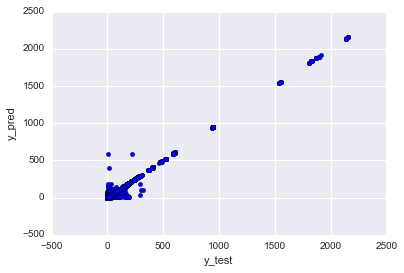

In [36]:
plt.scatter(y_test, y_pred)
#plt.xlim(0,1000)
#plt.ylim(0,1000)
plt.xlabel('y_test')
plt.ylabel('y_pred')

#Nested cross validation

Often we want to tune the parameters of a model (for example, C in a support vector machine). That is, we want to find the value of a parameter that minimizes our loss function. The best way to do this is cross validation:

1. Set the parameter you want to tune to some value.
2. Split your data into K 'folds' (sections).
3. Train your model using K-1 folds using the parameter value.
4. Test your model on the remaining fold.
5. Repeat steps 3 and 4 so that every fold is the test data once.
6. Repeat steps 1 to 5 for every possible value of the parameter.
7. Report the parameter that produced the best result.

However, as Cawley and Talbot point out in their 2010 paper, since we used the test set to both select the values of the parameter and evaluate the model, we risk optimistically biasing our model evaluations. For this reason, if a test set is used to select model parameters, then we need a different test set to get an unbiased evaluation of that selected model.

One way to overcome this problem is to have nested cross validations. First, an inner cross validation is used to tune the parameters and select the best model. Second, an outer cross validation is used to evaluate the model selected by the inner cross validation.

###Standardize data

In [16]:
# Create a scaler object
#sc = StandardScaler()

# Fit the scaler to the feature data and transform
#X_std = sc.fit_transform(X)

### Create Inner Cross Validation (For Parameter Tuning)

This is our inner cross validation. We will use this to hunt for the best parameters for C, the penalty for misclassifying a data point. GridSearchCV will conduct steps 1-6 listed at the top of this tutorial.

In [17]:
# Create a list of 10 candidate values for the C parameter
#max_depth_candidates = dict(max_depth=np.arange(1, 7, 1))

# Create a gridsearch object with the decision tree regressor and the max_depth value candidates
#reg = GridSearchCV(estimator=tree.DecisionTreeRegressor(), param_grid=max_depth_candidates)

The code below isn't necessary for parameter tuning using nested cross validation, however to demonstrate that our inner cross validation grid search can find the best value for the parameter C, we will run it once here:

In [18]:
# Fit the cross validated grid search on the data 
#reg.fit(X_std, y)

# Show the best value for C
#reg.best_estimator_.max_depth

### Create Outer Cross Validation (For Model Evaluation)

With our inner cross validation constructed, we can use cross_val_score to evaluate the model with a second (outer) cross validation.

The code below splits the data into three folds, running the inner cross validation on two of the folds (merged together) and then evaluating the model on the third fold. This is repeated three times so that every fold is used for testing once.

In [19]:
#print('Mean CV r2_score: {}'.format(np.mean(cross_val_score(reg, X_std, y, scoring='r2', cv=3))))

Each the values above is an unbiased evaluation of the model's accuracy, once for each of the three test folds. Averaged together, they would represent the average accuracy of the model found in the inner cross validated grid search.
